# Supervised Learning: Logistic Regression

This is what this excercise will cover:

1. Basic Mathematical Overview of the Logistic Function
2. Extra Math Resources
3. DataSet Analysis
4. Data Visualization
5. Data Preparation
6. Multicollinearity Consideration
7. Logistic Regression with SciKit Learn
8. Testing and Training Data Sets

The notebook from Jose Portilla could be found [here](http://nbviewer.jupyter.org/github/jmportilla/Udemy---Machine-Learning/blob/master/Supervised%20Learning%20-%20Logistic%20Regression.ipynb).

**Important**

To use logistic regression you need to install the module [statsmodels](http://statsmodels.sourceforge.net/).

In [1]:
# Initial imports

# Data imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Math
import math

# Plot imports
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

# For evaluation our ML results
from sklearn import metrics

# Dataset
import statsmodels.api as sm

## Part 1: Basic Mathematical Overview

The logistic regression is a model that predicts using a [logistic function](https://en.wikipedia.org/wiki/Logistic_function), that is an **S** shape function defined as:

<p style = "text-align: center">
$\alpha(t)=\frac{1}{1+e^{-t}}$
</p>

It is typically for binary classification with values lies, either from 0 to 0.5, or 0.5 to 1.

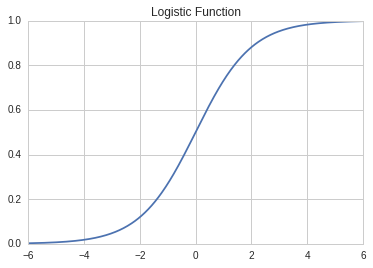

In [2]:
# Plot the logistic function

# Logistic regression function
def logistic(t):
    return 1.0 / (1 + math.exp(-1.0*t))

# Set t from -6 to 6 (500 elements, linearly spaced)
t = np.linspace(-6, 6, 500)

# Set up y values
y = np.array([logistic(element) for element in t])

# Plot the logistic S shape function
plt.plot(t, y)
plt.title("Logistic Function")

## Part 2: Extra Math Resources

To learn more about the math behind this method you can check the following resources:

1. [Andrew Ng's class notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf) on Logistic Regression.
2. [CMU notes](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf) that contains advanced math notation.
3. [Wikipedia page about logistic regression](https://en.wikipedia.org/wiki/Logistic_regression).

## Part 3: Dataset Analysis

For this analysis we are goint to use a dataset that is packaged within Statsmodels. It is a data set from a 1974 survey of women by Redbook magazine. Married women were asked if they have had extramarital affairs. The published work on the data set can be found [here](https://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf) and the description of the data set [here on the statsmodel website](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html).

The data fields at a glace are the following:

<pre>
Number of observations: 6366 Number of variables: 9

rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                4 = good, 5 = very good
age             : Age
yrs_married     : No. years married. Interval approximations. See
                original paper for detailed explanation.
children        : No. children
religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                4 = strongly
educ            : Level of education, 9 = grade school, 12 = high
                school, 14 = some college, 16 = college graduate,
                17 = some graduate school, 20 = advanced degree
occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                or unskilled worker; 3 = white-colloar; 4 = teacher
                counselor social worker, nurse; artist, writers;
                technician, skilled worker, 5 = managerial,
                administrative, business, 6 = professional with
                advanced degree
occupation_husb : Husband's occupation. Same as occupation.
affairs         : measure of time spent in extramarital affairs
</pre>

Using this dataset we are going to answer this question: **Given certain variables for each woman, can we classify them as either having particpated in an affair, or not participated in an affair?**.

## Part 4: Data Visualization

In [3]:
# Import the dataset from statsmodels to a data frame
df = sm.datasets.fair.load_pandas().data

In [4]:
df.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


In [5]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [6]:
# Now based on the affairs column we will create a new column named "Had_Affair".
# We will put a 1 if a woman has had an affair and a 0 if she hasn't.

# Function to set the value of "Has_Affair"
def affair_check(x):
    if x == 0:
        return 0
    else:
        return 1


In [7]:
df['Had_Affair'] = df['affairs'].apply(affair_check)

In [8]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,Had_Affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [9]:
# How many women has hadn't an affair
len(df.loc[df['Had_Affair'] == 0])

4313

In [10]:
# Now we group the dataframe by the "Had_Affair" field and calculate the mean of all the other fields
df.groupby('Had_Affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
Had_Affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


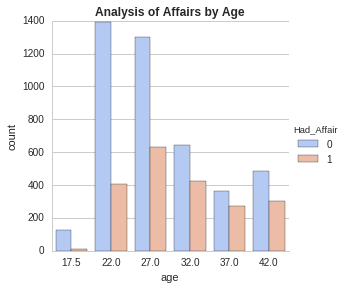

In [11]:
sns.factorplot('age', data = df, hue = 'Had_Affair', palette = 'coolwarm', kind = 'count')
plt.title("Analysis of Affairs by Age", weight = "bold")

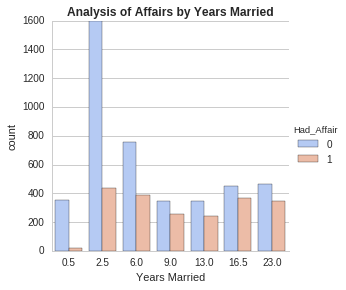

In [12]:
sns.factorplot('yrs_married', data = df, hue = 'Had_Affair', palette = 'coolwarm', kind = 'count')
plt.title("Analysis of Affairs by Years Married", weight = "bold")
plt.xlabel("Years Married")

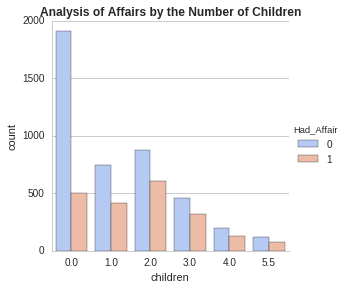

In [13]:
sns.factorplot('children', data = df, hue = 'Had_Affair', palette = 'coolwarm', kind = 'count')
plt.title("Analysis of Affairs by the Number of Children", weight = "bold")

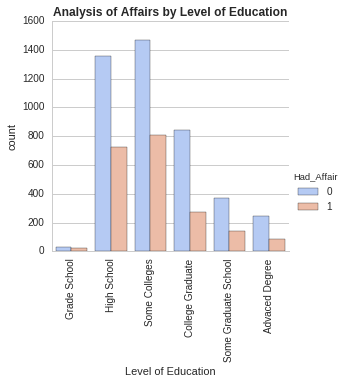

In [14]:
labels = ["Grade School", "High School", "Some Colleges", "College Graduate", "Some Graduate School", "Advaced Degree"]
g = sns.factorplot('educ', data = df, hue = 'Had_Affair', palette = 'coolwarm', kind = 'count')
g.set_xticklabels(labels, rotation = 90)
plt.title("Analysis of Affairs by Level of Education", weight = "bold")
plt.xlabel("Level of Education")

## Part 5: Data Preparation

In [15]:
# We create dummy variables for some categorical fiels: https://en.wikipedia.org/wiki/Dummy_variable_%28statistics%29

occ_dummies = pd.get_dummies(df['occupation'])
hus_occ_dummies = pd.get_dummies(df['occupation_husb'])

In [16]:
occ_dummies.head()

,1.0,2.0,3.0,4.0,5.0,6.0
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# Chance columns names for dummies dataframes

occ_dummies.columns = ['Student', 'Semi-Skilled Worker', 'White-Colloar', 'Skilled-Worker', 'Administrative', 
                       'Advanced Degree Professional']
hus_occ_dummies.columns = ['h-Student', 'h-Semi-Skilled Worker', 'h-White-Colloar', 'h-Skilled-Worker',
                                                'h-Administrative','h-Advanced Degree Professional']

In [18]:
occ_dummies.head()

,Student,Semi-Skilled Worker,White-Colloar,Skilled-Worker,Administrative,Advanced Degree Professional
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
hus_occ_dummies.head()

,h-Student,h-Semi-Skilled Worker,h-White-Colloar,h-Skilled-Worker,h-Administrative,h-Advanced Degree Professional
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
# Now we create the data for the logistic regression analysis
X = df.drop(['occupation', 'occupation_husb', 'Had_Affair'], axis = 1)

In [21]:
dummies = pd.concat([occ_dummies, hus_occ_dummies], axis = 1)

In [22]:
dummies.head()

,Student,Semi-Skilled Worker,White-Colloar,Skilled-Worker,Administrative,Advanced Degree Professional,h-Student,h-Semi-Skilled Worker,h-White-Colloar,h-Skilled-Worker,h-Administrative,h-Advanced Degree Professional
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
X.head()

,rate_marriage,age,yrs_married,children,religious,educ,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,4.666666


In [24]:
# 
X = pd.concat([X, dummies], axis = 1) # The training data

In [25]:
X.head()

,rate_marriage,age,yrs_married,children,religious,educ,affairs,Student,Semi-Skilled Worker,White-Colloar,Skilled-Worker,Administrative,Advanced Degree Professional,h-Student,h-Semi-Skilled Worker,h-White-Colloar,h-Skilled-Worker,h-Administrative,h-Advanced Degree Professional
0,3.0,32.0,9.0,3.0,3.0,17.0,0.111111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.230769,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,22.0,2.5,0.0,1.0,16.0,1.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,37.0,16.5,4.0,3.0,16.0,0.727273,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,27.0,9.0,1.0,1.0,14.0,4.666666,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
Y = df.Had_Affair # The target value of each row in the training data.

In [27]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: Had_Affair, dtype: int64

## Part 6: Multicollinearity Consideration

Now we need to get rid of a few columns. We will be dropping the **occ1** and **hocc1** columns to avoid [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity#Remedies_for_multicollinearity). Multicollinearity occurs due to the dummy variables) we created. This is because the dummy variables are highly correlated, our model begins to get distorted because one of the dummy variables can be linearly predicted from the others. We take care of this problem by dropping one of the dummy variables from each set, we do this at the cost of losing a data set point.

The other column we will drop is the **affairs** column. This is because it is basically a repeat of what will be our Y target, instead of 0 and 1 it just has 0 or a number, so we'll need to drop it for our target to make sense.

In [28]:
X.head()

,rate_marriage,age,yrs_married,children,religious,educ,affairs,Student,Semi-Skilled Worker,White-Colloar,Skilled-Worker,Administrative,Advanced Degree Professional,h-Student,h-Semi-Skilled Worker,h-White-Colloar,h-Skilled-Worker,h-Administrative,h-Advanced Degree Professional
0,3.0,32.0,9.0,3.0,3.0,17.0,0.111111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.230769,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,22.0,2.5,0.0,1.0,16.0,1.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,37.0,16.5,4.0,3.0,16.0,0.727273,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,27.0,9.0,1.0,1.0,14.0,4.666666,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
# We drop the mentioned columns
X = X.drop(["Student", "h-Student", "affairs"], axis = 1)

In [30]:
X.head()

,rate_marriage,age,yrs_married,children,religious,educ,Semi-Skilled Worker,White-Colloar,Skilled-Worker,Administrative,Advanced Degree Professional,h-Semi-Skilled Worker,h-White-Colloar,h-Skilled-Worker,h-Administrative,h-Advanced Degree Professional
0,3.0,32.0,9.0,3.0,3.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,27.0,13.0,3.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,22.0,2.5,0.0,1.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,37.0,16.5,4.0,3.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,27.0,9.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
# In order to use the Y with SciKit Learn, we need to set it as a 1-D array.
# This means we need to "flatten" the array. Numpy has a built in method for this called ravel.
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html
Y = np.ravel(Y)

In [33]:
Y # Y is now an array

array([1, 1, 1, ..., 0, 0, 0])

## Part 7: Logistic Regression with SciKit Learn

In [34]:
# We start creatind a logistic regression object
log_model = LogisticRegression()

In [35]:
# Now we fit our model
log_model.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
# Next we see the score of our model
log_model.score(X, Y)

0.72588752748978946

Looks like we got a **73% accuracy rating on our model**, among all the data only the 73% is correct or precise.

![Model Parametrs](data/svm_parameters.jpg)

In [38]:
# Now let's check the null error rate
Y.mean() # Percentage of women having an affair since it's the mean of the ones

0.32249450204209867

This means that if our model just simply guessed "no affair" we would have had **1 - 0.32 = 0.68 accuracy (or 68%) accuracy**.

Let's go ahead and check the coefficients of our model to check what seemed to be the stronger predictors, a **positive** value will mean that it's _increasing the likelihood_ of having an affair, a **negative** value it's _decreasing_ the likelihood of having an affair as the actual data value point increases.

In [39]:
coeff_df = DataFrame(zip(X.columns, np.transpose(log_model.coef_)))

In [41]:
coeff_df.columns = ["Feature", "Coefficient"]

In [42]:
coeff_df

,Feature,Coefficient
0,rate_marriage,[-0.697924125998]
1,age,[-0.0563646299078]
2,yrs_married,[0.103919041638]
3,children,[0.0181622363802]
4,religious,[-0.368517662336]
5,educ,[0.00875505261517]
6,Semi-Skilled Worker,[0.298052262971]
7,White-Colloar,[0.607992729515]
8,Skilled-Worker,[0.346221679741]
9,Administrative,[0.942505111823]


Since all the dummy variables (the wife and husband occupations) are positive that means **the lowest likelihood of having an affair** corresponds to the baseline occupation we dropped **(1-Student)**.

## Part 8: Testing and Training Data Sets

In [43]:
# Creating training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [44]:
# Train the model
log_model2 = LogisticRegression()

In [52]:
log_model2.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
# Now we predict the Y values (the testing values) using our trained model and using X_test
classification_predict = log_model2.predict(X_test)

In [56]:
# Now we check the accuracy of our model constasting the prediction agains the real values
print metrics.accuracy_score(Y_test, classification_predict)

0.702261306533


We get a **70.23%** of accuracy, similar to the value using all the data.

Now we will see two other metrics, precission and recall. More info: https://en.wikipedia.org/wiki/Precision_and_recall.

Precision is "how useful the results are", and recall is "how complete the results are"

In [87]:
metrics.precision_score(Y_test, classification_predict)

0.62152777777777779

In [88]:
metrics.recall_score(Y_test, classification_predict)

0.32904411764705882

Now we will comparte the expected values (Y_test) against the predicted values to have a visualization about accuracy.

In [67]:
comp_df = DataFrame(zip(Y_test, np.transpose(classification_predict)))
comp_df.columns = ["Expected Value", "Predicted Value"]

In [68]:
comp_df

,Expected Value,Predicted Value
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,0
